## 1-Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import numpy as np
import datetime
import pandas as pd
import sklearn as sk
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

## 2- Import cleaned data

In [2]:
# Load the data
data = pd.read_csv('/Users/alijanehsan/Downloads/Final_project/merge.csv', index_col =0)


In [3]:
data.head()

,date,item_code,quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,site,Revenue,country,...,gender,age,color,size,kids,men,unisex,women,day,month
0,2022-01-14,ZB00245086,1,107.443868,63.815891,126.367186,E-COMMER,top4running.at,107.443868,Austria,...,men,adults,White,44,0,1,0,0,Friday,January
1,2021-12-09,ZB00245086,1,98.582325,63.816279,129.458420,E-COMMER,top4running.it,98.582325,Italy,...,men,adults,White,44,0,1,0,0,Thursday,December
2,2021-12-08,ZB00245086,1,100.182074,63.815891,131.559296,E-COMMER,top4running.at,100.182074,Austria,...,men,adults,White,44,0,1,0,0,Wednesday,December
3,2021-12-04,ZB00245086,1,98.350139,63.816279,129.153514,E-COMMER,top4running.it,98.350139,Italy,...,men,adults,White,44,0,1,0,0,Saturday,December
4,2021-11-14,ZB00245086,1,99.296899,63.815891,130.396884,E-COMMER,top4running.at,99.296899,Austria,...,men,adults,White,44,0,1,0,0,Sunday,November


In [4]:
data.shape

(1911344, 26)

## 3- Get weekly data

In [5]:
def weekly_data(data, time_period='week', Revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'Revenue'}
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    data = data[revenue_cat[Revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [6]:
df_w = weekly_data(data)
#df_w.columns=['ds', 'y']
df_w.ds=pd.to_datetime(df_w['date'])
df_w.sort_values('date')
df_w.head()

<ipython-input-6-b7108d84497e>:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,date,Revenue
0,2019-06-02,2230.325449
1,2019-06-09,126002.067330
2,2019-06-16,95903.992858
3,2019-06-23,144376.361788
4,2019-06-30,89564.752806


## 4- Check the data whether it is stationary or not, if not make it stationary

In [7]:
# Plot the data and see whether the data is stationary or not
plot_data = [
    go.Scatter(
        x=df_w['date'],
        y=df_w['Revenue'],
    )
]
plot_layout = go.Layout(
        title='daily Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

 Check with Dicky-Fuller test as well

In [8]:
# Check the data with Dicky-Fuller test
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_w['Revenue'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -2.161648
p-value                          0.220458
#lags used                       5.000000
number of observations used    132.000000
critical value (1%)             -3.480888
critical value (5%)             -2.883697
critical value (10%)            -2.578586
dtype: float64


Since the p-value is greater than  5% and T Statistic is greater than critical values, we have to make the data stationary

In [9]:
df_diff = df_w.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['Revenue'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Revenue'] - df_diff['prev_sales'])
df_diff.head(10)

,date,Revenue,prev_sales,diff
1,2019-06-09,126002.067330,2230.325449,123771.741881
2,2019-06-16,95903.992858,126002.067330,-30098.074472
3,2019-06-23,144376.361788,95903.992858,48472.368930
4,2019-06-30,89564.752806,144376.361788,-54811.608982
5,2019-07-07,131050.565614,89564.752806,41485.812809
6,2019-07-14,157671.533742,131050.565614,26620.968127
7,2019-07-21,147705.704362,157671.533742,-9965.829380
8,2019-07-28,141037.690288,147705.704362,-6668.014074
9,2019-08-04,180209.357178,141037.690288,39171.666890
10,2019-08-11,208612.843837,180209.357178,28403.486659


Check the data agian 

In [10]:
# Plot the data and see whether the data is stationary or not
plot_data = [
    go.Scatter(
        x=df_diff['date'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='weekly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Now  our data looks stationary

## 5- Make the data ready for fb Prophet modeling

In [11]:
df_w2 = df_diff[['date','diff']]
df_w2.columns = ['ds','y']
df_w2.sort_values('ds')


,ds,y
1,2019-06-09,123771.741881
2,2019-06-16,-30098.074472
3,2019-06-23,48472.368930
4,2019-06-30,-54811.608982
5,2019-07-07,41485.812809
...,...,...
133,2021-12-19,-127656.986723
134,2021-12-26,-315737.176227
135,2022-01-02,16606.577613
136,2022-01-09,64841.467999


## 6- Split the data into test and training set

In [12]:
len(df_w2)

137

In [14]:
#Split our data into test and train set
train=df_w2[:107]
test=df_w2[107:]

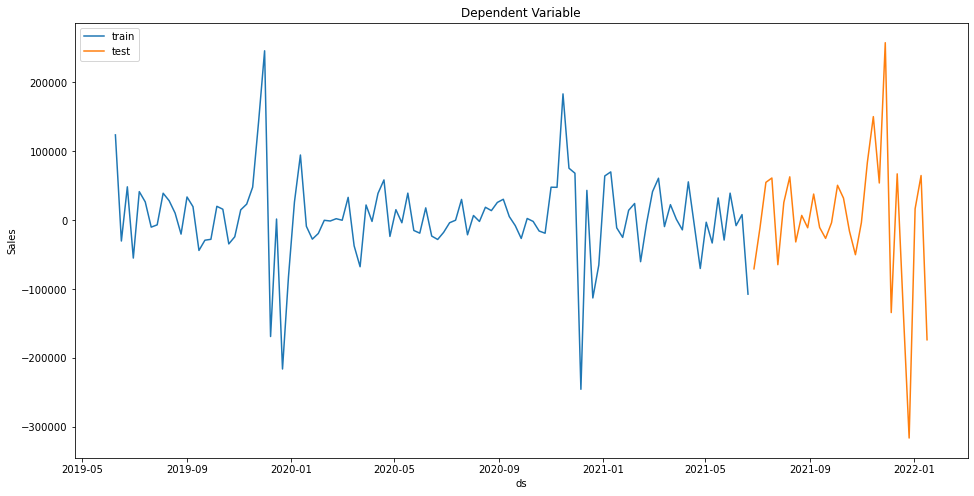

In [15]:
# Lets plot the both data
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test, ax=ax)
plt.ticklabel_format(style='plain', axis='y')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')

## 7- Modeling

In [ ]:
m = Prophet(weekly_seasonality=True,yearly_seasonality=True)
m.add_seasonality(name='weekly', period=len(train), fourier_order=4)
#m.add_country_holidays(country_name='UK')
m.fit(train)

In [17]:
future = m.make_future_dataframe(periods= test.shape[0]+5, freq = 'W')
forecast = m.predict(future)
forecast

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-09,95842.242009,-45379.715058,83177.185122,95842.242009,95842.242009,-78592.457473,-78592.457473,-78592.457473,-82995.599428,-82995.599428,-82995.599428,4403.141955,4403.141955,4403.141955,0.0,0.0,0.0,17249.784536
1,2019-06-16,95658.129239,-62089.268579,57833.325004,95658.129239,95658.129239,-98871.730021,-98871.730021,-98871.730021,-82995.599428,-82995.599428,-82995.599428,-15876.130593,-15876.130593,-15876.130593,0.0,0.0,0.0,-3213.600782
2,2019-06-23,95474.016469,-73555.301354,50711.604202,95474.016469,95474.016469,-107669.907852,-107669.907852,-107669.907852,-82995.599428,-82995.599428,-82995.599428,-24674.308424,-24674.308424,-24674.308424,0.0,0.0,0.0,-12195.891383
3,2019-06-30,95289.903699,-72434.384684,53827.536581,95289.903699,95289.903699,-102999.938251,-102999.938251,-102999.938251,-82995.599428,-82995.599428,-82995.599428,-20004.338823,-20004.338823,-20004.338823,0.0,0.0,0.0,-7710.034552
4,2019-07-07,95105.790929,-59412.338568,69194.889997,95105.790929,95105.790929,-92000.433239,-92000.433239,-92000.433239,-82995.599428,-82995.599428,-82995.599428,-9004.833811,-9004.833811,-9004.833811,0.0,0.0,0.0,3105.357690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2022-01-23,71007.032908,-74963.880519,53812.414839,70994.699442,71018.615524,-82496.834277,-82496.834277,-82496.834277,-82995.599428,-82995.599428,-82995.599428,498.765151,498.765151,498.765151,0.0,0.0,0.0,-11489.801369
138,2022-01-30,70826.449579,-99173.986923,24081.333539,70813.518891,70838.645762,-107349.274993,-107349.274993,-107349.274993,-82995.599428,-82995.599428,-82995.599428,-24353.675565,-24353.675565,-24353.675565,0.0,0.0,0.0,-36522.825414
139,2022-02-06,70645.866250,-101734.594819,27809.112616,70632.411083,70658.746023,-108091.944200,-108091.944200,-108091.944200,-82995.599428,-82995.599428,-82995.599428,-25096.344772,-25096.344772,-25096.344772,0.0,0.0,0.0,-37446.077951
140,2022-02-13,70465.282920,-86495.043804,43152.487772,70451.140581,70479.014333,-91442.330987,-91442.330987,-91442.330987,-82995.599428,-82995.599428,-82995.599428,-8446.731559,-8446.731559,-8446.731559,0.0,0.0,0.0,-20977.048066


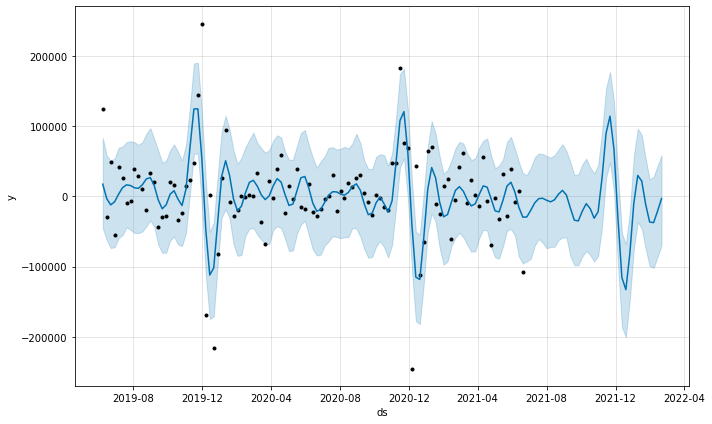

In [18]:
# plot the forecast
fig1 = m.plot(forecast)

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



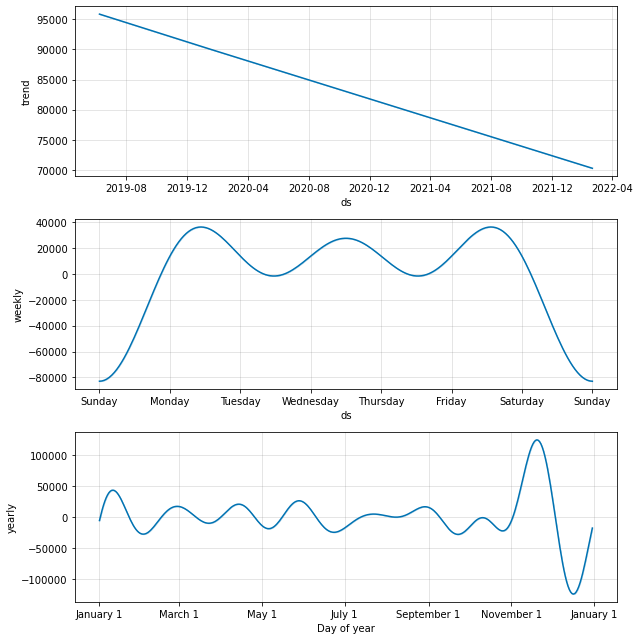

In [20]:
# plot the components
fig2 = m.plot_components(forecast)

Comapare the predicted values with actual values

<function matplotlib.pyplot.show(close=None, block=None)>

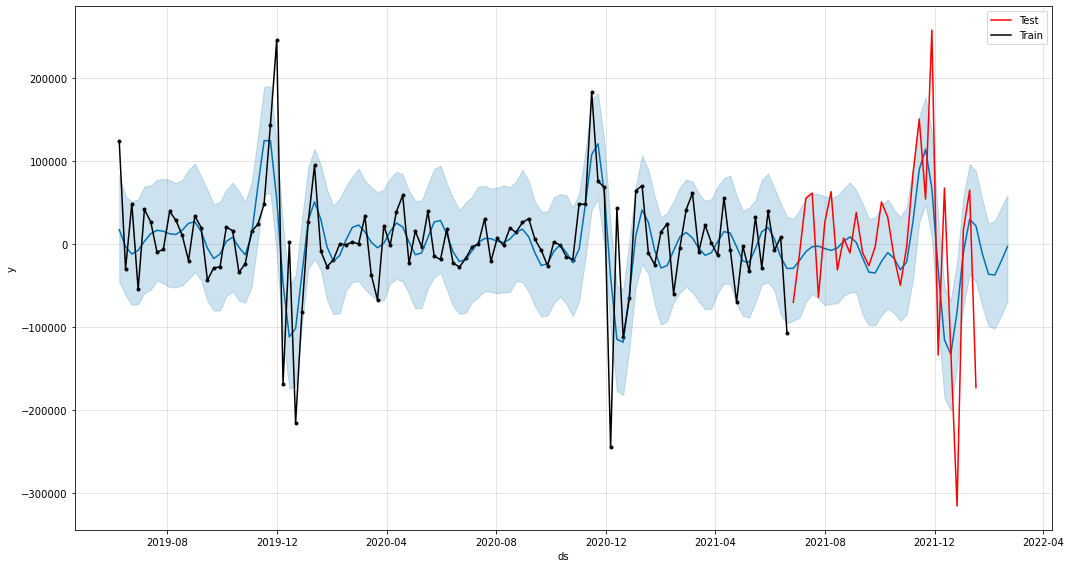

In [22]:
# Let's coampare the prediction with actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=m.plot(forecast, ax=ax)
ax.plot(test.ds, test.y, color='r', label='Test')
ax.plot(train.ds, train.y, color='black', label='Train')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show

## 8- Evaluate the model

In [23]:
df_merge = pd.merge(test, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-06-27,-92642.624102,30117.247787,-29441.769644,-70429.549828
1,2021-07-04,-88731.862636,40539.201001,-19846.029388,-11306.273348
2,2021-07-11,-70205.224816,55399.374756,-9360.051909,54966.619046
3,2021-07-18,-60726.371239,60898.925183,-3340.095915,61275.409867
4,2021-07-25,-65765.220750,60322.958663,-2757.830840,-64423.392844


In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
#mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print('MAPE:',mape_01)

MAPE: 1.3406892647510056


## 9- Crossvalidation

In [28]:
from fbprophet.diagnostics import cross_validation
df_cv=cross_validation(model=m, horizon='30 days', period='30 days')
mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2020-06-25 00:00:00 and 2021-05-21 00:00:00
  0%|          | 0/12 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1/12 [00:05<01:02,  5.65s/it]/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

MAPE:  15.976226351864277


Performance metrics

In [29]:
from fbprophet.diagnostics import performance_metrics
per_df = performance_metrics(df_cv)
per_df.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1.013068e+09,31828.731559,25194.781095,1.290176,1.943839,1.0
1,4 days,2.245259e+09,47384.167894,35231.812028,1.073170,1.271928,0.8
2,5 days,1.922107e+09,43841.845736,29813.959935,0.826858,0.285062,0.8
3,6 days,1.867768e+09,43217.687170,30262.824651,2.503175,1.271928,0.8
4,7 days,1.396963e+09,37375.973964,28692.241019,2.465874,0.591991,0.9


Compare the predicted values with actual values after crossvalidation

Text(0.5, 1.0, 'Forecast Vs Actual')

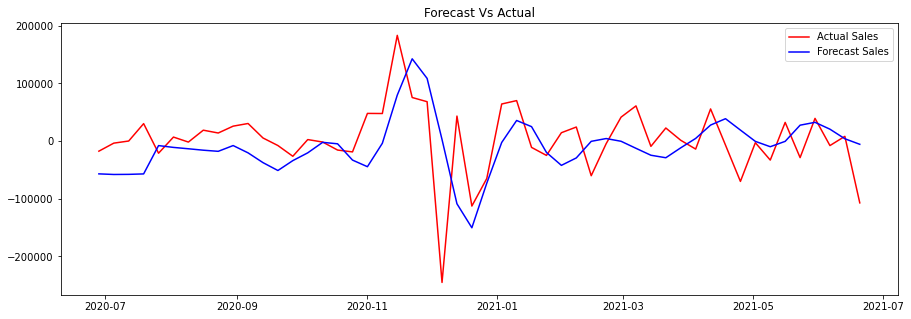

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()

plt.title('Forecast Vs Actual')

## 10- Tunning parameters

In [31]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],   
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, horizon='7days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 106 forecasts with cutoffs between 2020-06-10 12:00:00 and 2021-06-13 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe56a664070>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a fu

In [32]:
tuning_results.sort_values(['mae','mape'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
0,0.001,0.01,36929.403984,2.822618
12,0.500,0.01,37095.700947,3.249046
8,0.100,0.01,37118.742162,3.238134
1,0.001,0.10,39162.276328,7.635945
9,0.100,0.10,39307.144053,7.619950
13,0.500,0.10,39621.430475,7.585758
4,0.010,0.01,39656.512123,3.091043
2,0.001,1.00,41734.092360,8.673102
3,0.001,10.00,42014.881015,6.543504
10,0.100,1.00,42025.781046,8.748242


## 12-  Finding the best  parameters and compare the results

In [33]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [ ]:
# Train the model with best parameters
m_01 = Prophet(weekly_seasonality=True,yearly_seasonality=True,
changepoint_prior_scale = best_params['changepoint_prior_scale'],
seasonality_prior_scale = best_params['seasonality_prior_scale'] )
m_01.add_seasonality(name='monthly', period=24, fourier_order=1)
#m.add_country_holidays(country_name='UK')
model = m_01.fit(train)

In [35]:
future_01 = model.make_future_dataframe(periods=7, freq = 'W')
forecast_01 = model.predict(future_01)

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## 13- Check the model peformance after tunning the parameters

In [36]:
df_merge_1 = pd.merge(test, forecast_01[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge_1 = df_merge_1[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge_1.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-06-27,-89545.555029,63772.566786,-4696.725923,-70429.549828
1,2021-07-04,-78326.849047,71570.706474,-6070.222481,-11306.273348
2,2021-07-11,-79178.374599,71754.221814,-5216.612529,54966.619046
3,2021-07-18,-84861.711234,68185.245859,-2560.471594,61275.409867
4,2021-07-25,-80417.174543,65947.411307,-3873.537162,-64423.392844


Check the model performance before parameters tuning


In [37]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
#mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)

print('mape before tuning parameters:',mape_01)

mape before tuning parameters: 1.3406892647510056


 Check the model perfomance after tuning the parameters

In [38]:
y_true_01 = df_merge_1['y'].values
y_pred_01= df_merge_1['yhat'].values
#mae_02 = mean_absolute_error(y_true_01, y_pred_01)
mape_02 = mean_absolute_percentage_error(y_true_01, y_pred_01)

print('mape after tuning prarameters:',mape_02)

mape after tuning prarameters: 0.9673902729911565


 We can see that after fine-parameter tuning mape decreased from 1.3406892647510056 to 0.9673902729911565 which is a good sign of improvement

(0.0, 5.0)